In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.linalg 

In [50]:
def gen_desmat_gaussian(X, params):
  s = params['s']
  mus = params['mus']
  Phi = np.zeros((len(X),len(mus)+1))
  Phi[:,0] = np.ones(len(X)) # the 0-the basis is a constant
  A = ( -2*(X@(mus.T)) + np.reshape(np.sum(X**2, axis=1), (len(X), -1)) ) + np.sum(mus**2, axis=1)
  Phi[:,1:] = np.exp(-A/(2*s*s))
  return Phi

In [64]:
class BayesianRidgeRegression(object):
  def __init__(self, alpha=1.0, beta=1.0):
    self.alpha = alpha
    self.beta = beta
    self.m = None
    self.S = None

  def calc_posterior_params(self, Phi, t):
    self.S = np.linalg.pinv(self.alpha * np.eye(len(Phi[0])) + self.beta * (Phi.T)@Phi)
    self.m = self.beta * (self.S @ Phi.T @ t)

  def predict(self,Phi, return_std=True):
    pred_std = np.sqrt(1.0/self.beta + np.diag(Phi @ self.S @ (Phi.T) ) )
    pred_mean = Phi @ self.m
    if not(return_std):
      return pred_mean
    else:
      return pred_mean, pred_std

  def calc_evidence(self, Phi, t):
    N, M = Phi.shape
    evidence = 0.5*M*np.log(self.alpha) + 0.5*N*np.log(self.beta) \
            - 0.5*self.beta*np.linalg.norm( t - Phi @ self.m )**2 - 0.5*self.alpha*(self.m@self.m) \
            - 0.5*np.log( np.linalg.det( self.alpha*np.identity(M) + self.beta*(Phi.T)@Phi ) ) \
            - 0.5*N*np.log(2*np.pi)
    return evidence

  def empirical_bayes(self, Phi, t, tol, maxiter, show_message=True):
    tmp_lambdas = scipy.linalg.eigh((Phi.T)@Phi)[0]
    cnt = 0
    while cnt < maxiter:
      lambdas = self.beta * tmp_lambdas
      self.calc_posterior_params(Phi, t)

      alpha_old = self.alpha
      beta_old = self.beta

      gamma = np.sum( lambdas/ (self.alpha + lambdas))
      self.alpha = gamma/np.dot(self.m, self.m)
      self.beta = (len(t) - gamma) / (np.linalg.norm(t - Phi @ self.m) ** 2)
      if (abs(self.alpha - alpha_old) < tol) and ( abs(self.beta - beta_old) < tol):
        break
      cnt += 1

    if show_message:
      if cnt <= maxiter:
        print(f"Optimization terminated succesfully. The number of iteration : {cnt}")
      else:
        pritn('Maximun number of iteration exceeded.')
  
  def fit(self, Phi, t, tol=1e-4, maxiter=100, show_message=True, optimize_hyperparams=False):
        if optimize_hyperparams:
            self.empirical_bayes(Phi, t, tol, maxiter, show_message)
        self.calc_posterior_params(Phi, t) 

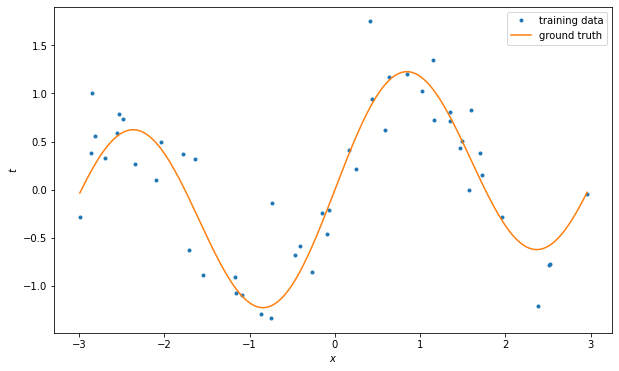

In [66]:
def truef(x):
    return np.sin(2*x)  + 0.2*np.sin(x) + 0.1*x

N = 50
X = np.random.uniform(-3, 3, N)
ep = 0.3*np.random.randn(N)
t = truef(X) + ep

Xcont = np.linspace(np.min(X),np.max(X),200) # for plotting

plt.figure(figsize=(10,6))
plt.plot(X, t,'.', label='training data')
plt.plot(Xcont, truef(Xcont), label='ground truth')
plt.xlabel(r'$x$')
plt.ylabel(r'$t$')
plt.legend()
plt.show()

X = np.reshape(X,(len(X),1))
Xtest = np.reshape(Xcont,(len(Xcont),1))

In [57]:
def plot_result(pred_mean, pred_std):
  plt.figure(figsize=(10,6))
  plt.plot(X, t, '.', label="Train data")
  plt.plot(Xcont, pred_mean, label='predictive mean')
  plt.plot(Xcont, truef(Xcont), ':', label='Correct')
  plt.fill_between(Xcont, pred_mean+pred_std, pred_mean-pred_std, alpha=0.2)
  plt.xlabel("x")
  plt.legend()
  plt.show()
def plot_prediction_fixed_hparams(x, mus, alpha, beta):
  Phi = gen_desmat_gaussian(X,params={'s':s, 'mus':mus})
  Phi_test = gen_desmat_gaussian(Xtest,params={'s':s, 'mus':mus})
    
  est = BayesianRidgeRegression(alpha=alpha, beta=beta)
  est.fit(Phi, t, optimize_hyperparams=False)
  pred_mean, pred_std = est.predict(Phi_test, return_std=True)
  plot_result(pred_mean, pred_std)

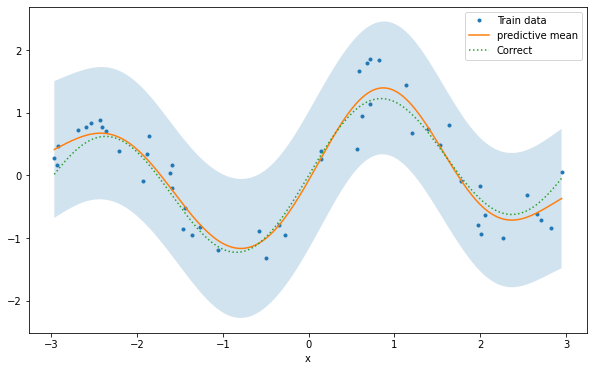

In [58]:
mus = np.reshape(np.linspace(-3,3,16),(16,1))
s = 0.5
plot_prediction_fixed_hparams(s, mus, alpha=1.0, beta=1.0)

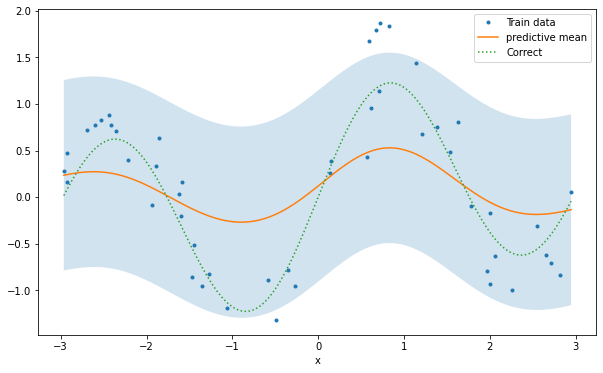

In [59]:
mus = np.reshape(np.linspace(-3,3,16),(16,1))
s = 0.5
plot_prediction_fixed_hparams(s, mus, alpha=30.0, beta=1.0)

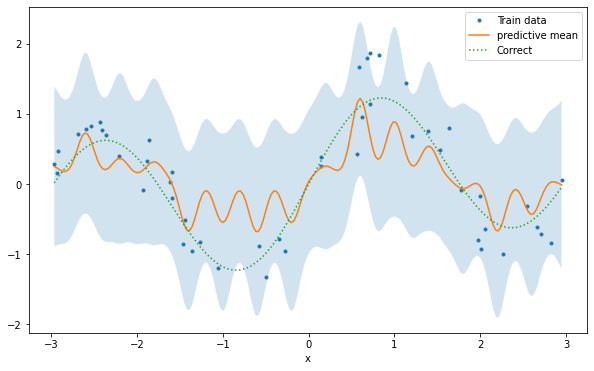

In [60]:
mus = np.reshape(np.linspace(-3,3,16),(16,1))
s = 0.1
plot_prediction_fixed_hparams(s, mus, alpha=1.0, beta=1.0)

Optimization terminated succesfully. The number of iteration : 3
alpha=3.1417678892108953 
beta=9.80793296350386


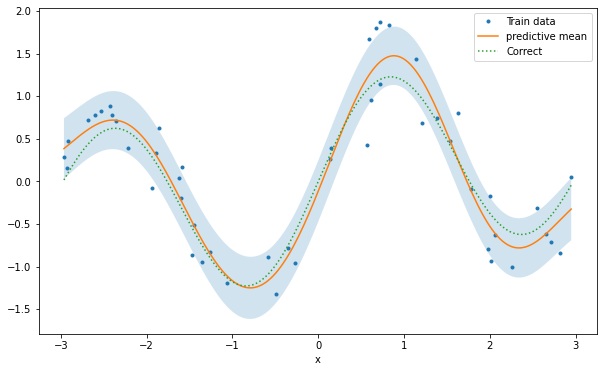

In [65]:
mus = np.reshape(np.linspace(-3,3,16),(16,1))
s = 0.5
params = {'s':s, 'mus':mus}
Phi = gen_desmat_gaussian(X, params = {'s':s, 'mus':mus})
Phi_test = gen_desmat_gaussian(Xtest,params={'s':s, 'mus':mus})

est = BayesianRidgeRegression(alpha=1.0, beta=1.0)
est.fit(Phi, t, optimize_hyperparams=True)
pred_mean, pred_std = est.predict(Phi_test, return_std=True)

print(f"alpha={est.alpha} \nbeta={est.beta}")
plot_result(pred_mean, pred_std)